<h1>Data preprocessing</h1>

This notebook is used to create all the data files that will be used in the project. 

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# read data file
path = 'data/'
data = pd.read_excel(path + 'Oncothromb_bbddMarzo2018.xlsx')
print(data.shape)

(408, 92)


In [3]:
# using rows where excluido==0
data = data[data['excluido']==0]
data.shape

(391, 92)

## Using the variables considered in the TiC-Onco score

<img src="images/table3.png" alt="" width="400"/>

- I have considered *lung* as high risk ```HR``` tumour site and *stomach, pancreas* as very high risk ```VHR``` primary tumour sites.
- ```Tumour stage``` is 1 for stage 4 tumours and 0 elsewhere.

In [4]:
# clinical variables -> BMI, Family history, Primary tumour site and Tumour stage
clinical_vars = ['id','bmi','Family','tipusTumor_desc','estadiGrup','khorana'] # khorana is included for comparison purposes
df_clinical = data[clinical_vars]
df_clinical.shape

(391, 6)

In [5]:
df_clinical.isna().sum() # check NaNs

id                 0
bmi                0
Family             0
tipusTumor_desc    0
estadiGrup         0
khorana            1
dtype: int64

In [6]:
# preprocessing clinical data 

# BMI >25
df_clinical['bmi'].replace(['Underweight: BMI < 18.5 Kg/m2','Normal: BMI ~ 18.5-24.9 Kg/m2'], 0, inplace=True)
df_clinical['bmi'].replace(['Overweight: BMI ~25-29.9 Kg/m2','Obese: BMI > 30 kg/m2'], 1, inplace=True)

# HR / VHR
df_clinical['tipusTumor_HR'] = [1 if t=='Cáncer de pulmón no microcítico' else 0 for t in df_clinical['tipusTumor_desc']]
df_clinical['tipusTumor_VHR'] = [1 if t in ['Cáncer de páncreas','Cáncer gástrico o de estómago'] else 0 for t in df_clinical['tipusTumor_desc']]
df_clinical.drop('tipusTumor_desc', axis=1, inplace=True)

# Tumour stage
df_clinical['estadiGrup'].replace(['IA','IB','IIA','IIB','IIC','III','IIIA','IIIB','IIIC'],0, inplace=True)
df_clinical['estadiGrup'].replace(['IV','IVA','IVB'],1, inplace=True)

In [7]:
df_clinical.head()

,id,bmi,Family,estadiGrup,khorana,tipusTumor_HR,tipusTumor_VHR
1,1,1,0,1,2.0,0,0
2,14,0,0,0,2.0,0,1
3,67,0,0,1,1.0,1,0
4,91,0,0,1,0.0,0,0
5,68,1,0,1,0.0,0,0


In [8]:
# genetic variables -> rs2232698, rs6025, rs5985, rs4524
genetic_vars = ['id','rs2232698','rs6025','rs5985','rs4524']
df_genetic = data[genetic_vars]
df_genetic.shape

(391, 5)

In [9]:
df_genetic.replace('NoCall', np.NaN, inplace=True) # convert NoCall to NaN

In [10]:
df_genetic.isna().sum() # check NaNs

id           0
rs2232698    1
rs6025       0
rs5985       0
rs4524       0
dtype: int64

In [11]:
df_genetic.fillna('CC', inplace=True) # input missing value with 'CC' (the mode)

In [12]:
# preprocessing genetic variables (number of risk alelles)
df_genetic['rs2232698'].replace(['CC','CT'], [0,1], inplace=True)
df_genetic['rs6025'].replace(['GG','AG'], [0,1], inplace=True)
df_genetic['rs5985'].replace(['GG','GT','TT'], [0,1,2], inplace=True)
df_genetic['rs4524'].replace(['CC','CT','TT'], [0,1,2], inplace=True)

In [13]:
df_genetic.head()

,id,rs2232698,rs6025,rs5985,rs4524
1,1,0,0,1,1
2,14,0,0,0,1
3,67,0,0,0,2
4,91,0,0,0,2
5,68,0,0,0,2


In [14]:
# merge both dataframes (clinical & genetic)
ids = list(set(df_clinical['id'].values) & set(df_genetic['id'].values))
df = df_clinical[df_clinical['id'].isin(ids)].merge(df_genetic[df_genetic['id'].isin(ids)], on=['id'])
df.shape

(391, 11)

### Target variable

Target variable ```caseAtVisit``` indicates whether patients suffered VTE during the monitoring period:
- ```caseAtVisit==0```: VTE at 0 months
- ```caseAtVisit==1```: VTE at 6 months
- ```caseAtVisit==2```: VTE at 12 months
- ```caseAtVisit==3```: VTE at 18 months
- ```caseAtVisit==NaN```: No VTE

Here we consider ```y=1``` if the patient suffered an VTE within the first 6 months (```caseAtVisit==0``` or ```caseAtVisit==1```) and ```y=0``` elsewhere.

In [15]:
# target variable
y = data[data['id'].isin(ids)]['caseAtVisit']
y = pd.Series([1 if x in [0,1] else 0 for x in y])
y.value_counts()

0    318
1     73
dtype: int64

In [16]:
# add target as a column
df['VTE'] = y

df.head()

,id,bmi,Family,estadiGrup,khorana,tipusTumor_HR,tipusTumor_VHR,rs2232698,rs6025,rs5985,rs4524,VTE
0,1,1,0,1,2.0,0,0,0,0,1,1,1
1,14,0,0,0,2.0,0,1,0,0,0,1,0
2,67,0,0,1,1.0,1,0,0,0,0,2,0
3,91,0,0,1,0.0,0,0,0,0,0,2,0
4,68,1,0,1,0.0,0,0,0,0,0,2,1


In [17]:
# save dataframe to file
df.to_csv(path+'data_TiC_Onco.csv', index=False)

In [18]:
from utils import print_summary

X = df[df.columns.difference(['id','VTE'])]
y = df['VTE']

print_summary(X,y) # population characteristics


                      Variable  VTE (n)  VTE (%)  No-VTE (n)  No-VTE (%)
0                            N       73    100.0         318       100.0
1                       Family        6      8.2          12         3.8
2                          bmi       37     50.7         145        45.6
3                   estadiGrup       49     67.1         132        41.5
4   rs2232698 - 0 risk alleles       69     94.5         313        98.4
5    rs2232698 - 1 risk allele        4      5.5           5         1.6
6      rs4524 - 0 risk alleles        1      1.4          22         6.9
7       rs4524 - 1 risk allele       23     31.5         114        35.8
8      rs4524 - 2 risk alleles       49     67.1         182        57.2
9      rs5985 - 0 risk alleles       38     52.1         182        57.2
10      rs5985 - 1 risk allele       30     41.1         119        37.4
11     rs5985 - 2 risk alleles        5      6.8          17         5.3
12     rs6025 - 0 risk alleles       70     95.9  

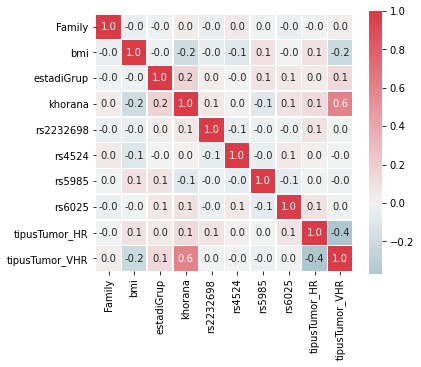

In [23]:
from utils import corr_heatmap

corr_heatmap(X, figsize=(6,6))